In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statistics
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.set_option('display.max_columns', None)

df = pd.read_csv('/kaggle/input/playground-series-s3e25/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e25/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s3e25/sample_submission.csv')
mineral_original = pd.read_csv('/kaggle/input/prediction-of-mohs-hardness-with-machine-learning/jm79zfps6b-1/Mineral_Dataset_Supplementary_Info.csv')
crystals_original = pd.read_csv('/kaggle/input/prediction-of-mohs-hardness-with-machine-learning/jm79zfps6b-1/Artificial_Crystals_Dataset.csv')

/kaggle/input/playground-series-s3e25/sample_submission.csv
/kaggle/input/playground-series-s3e25/train.csv
/kaggle/input/playground-series-s3e25/test.csv
/kaggle/input/prediction-of-mohs-hardness-with-machine-learning/jm79zfps6b-1/Mineral_Dataset_Supplementary_Info.csv
/kaggle/input/prediction-of-mohs-hardness-with-machine-learning/jm79zfps6b-1/Artificial_Crystals_Dataset.csv


| Version | Notes | CV score |Public LB Score|
| :-: | --- | :-: | :-:|
| **V2** |Only train data is used |0.5225| 0.49496|
| **V5** |Train and Original data <br> Best CV LB correlation |0.5091| 0.50969|
| **V8** |Add Meta Data <br> Best CV so far <br> Best LB so far |0.5047| 0.49253|

This notebook builds a regressor model for the **Playground Series Season 3 Episode 25** competition. The dataset for this competition (both train and test) was generated from a deep learning model trained on the **Joy Garnett's Mohs Hardness** dataset. For this specific episode, the models are evaluated on the Median Absolute Error.

This metric is useful in situations where you want a measure of accuracy that is less sensitive to outliers and can be read as 'typical' error in predictions. A MedAE of x means that half of your errors are less than x and half are greater.

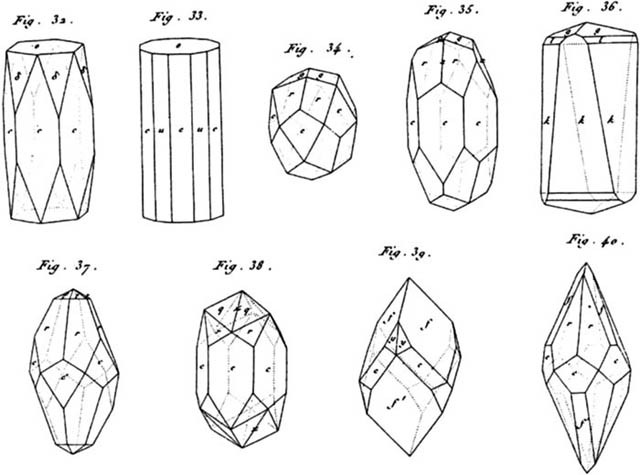



*Schneer, C.J. (1981). Crystal habit . In: Mineralogy. Encyclopedia of Earth Science. Springer, Boston, MA.*

In [2]:
rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

In [3]:
df.drop(columns='id', inplace=True)
test.drop(columns='id', inplace=True)
df.head(5)

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


Explanation of each feature can be found in the paper *Prediction of Mohs Hardness with Machine Learning Methods* by Joy C.Garnet.

* **allelectrons_Total:** Total number of electrons
* **density_Total:** Total elemental density
* **allelectrons_Average**: Atomic average number of electrons
* **val_e_Average**: Atomic average number of valence electrons
* **atomicweight_Average**: Atomic average atomic weight
* **ionenergy_Average**: Atomic average frst IE
* **el_neg_chi_Average**: Atomic average Pauling electronegativity of the most common oxidation state
* **R_vdw_element_Average**: Atomic average van der Waals atomic radius
* **R_cov_element_Average**: Atomic average covalent atomic radius
* **zaratio_Average**: Atomic average atomic number to mass number ratio
* **density_Average**: Atomic average elemental density
* **Hardness**: Mohs hardness (target)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  float64
 1   density_Total          10407 non-null  float64
 2   allelectrons_Average   10407 non-null  float64
 3   val_e_Average          10407 non-null  float64
 4   atomicweight_Average   10407 non-null  float64
 5   ionenergy_Average      10407 non-null  float64
 6   el_neg_chi_Average     10407 non-null  float64
 7   R_vdw_element_Average  10407 non-null  float64
 8   R_cov_element_Average  10407 non-null  float64
 9   zaratio_Average        10407 non-null  float64
 10  density_Average        10407 non-null  float64
 11  Hardness               10407 non-null  float64
dtypes: float64(12)
memory usage: 975.8 KB


In [5]:
df.shape

(10407, 12)

In [6]:
def drop_missing_rows(df):
    if df.isnull().any().any():
        print("Missing values found in the dataframe.")
        df = df.dropna(axis=0)
        dropped_rows = len(df) - len(df.dropna())
        print(f"Dropped {dropped_rows} rows.")
    else:
        print("No missing values found in the dataframe.")

    return df

df = drop_missing_rows(df)
test = drop_missing_rows(test)

No missing values found in the dataframe.
No missing values found in the dataframe.


In [7]:
def count_duplicate_rows(df):
    duplicate_rows = df[df.duplicated()]
    
    if not duplicate_rows.empty:
        print("Duplicate rows found in the dataframe.")
        count = len(duplicate_rows)
        print(f"Count of duplicate rows: {count}.")
    else:
        print("No duplicate rows found in the dataframe.")

    return df

df = count_duplicate_rows(df)
test = count_duplicate_rows(test)

No duplicate rows found in the dataframe.
No duplicate rows found in the dataframe.


In [8]:
def count_duplicate_rows_target(df, target_column):
    columns_to_check = df.columns.difference([target_column])
    duplicate_rows = df[df.duplicated(subset=columns_to_check)]
    
    if not duplicate_rows.empty:
        print("Duplicate rows found in the dataframe (excluding target feature).")
        count = len(duplicate_rows)
        print(f"Count of duplicate rows: {count}.")
    else:
        print("No duplicate rows found in the dataframe (excluding target feature).")

    return df

df = count_duplicate_rows_target(df, 'Hardness')

No duplicate rows found in the dataframe (excluding target feature).


## Initial Analysis
-----------------------------------------------------------------------------------

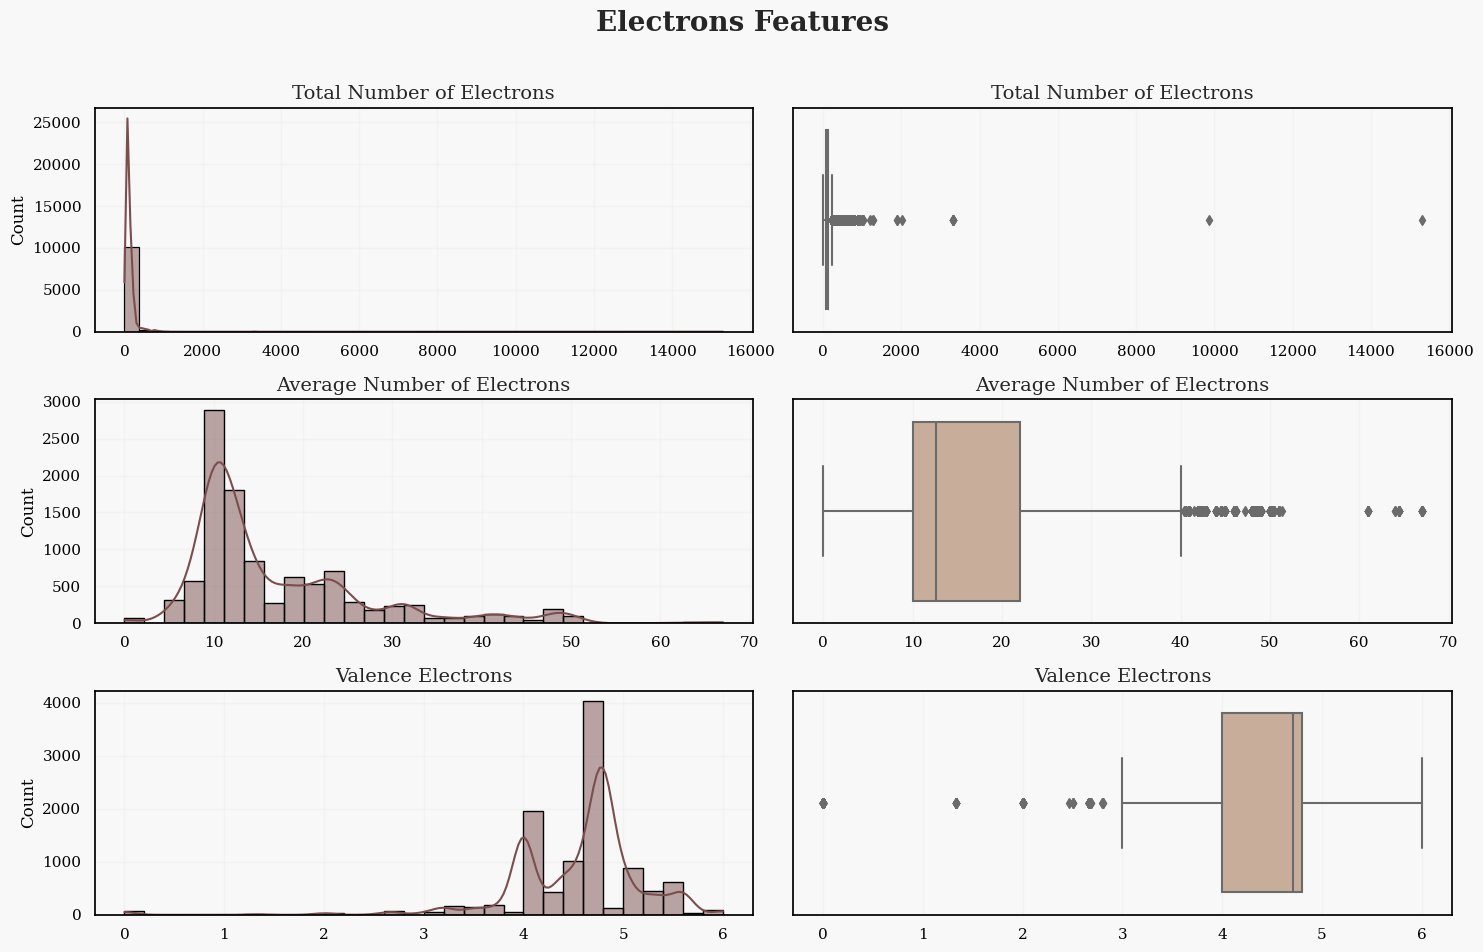

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

sns.histplot(df['allelectrons_Total'], ax=axes[0, 0], kde=True, bins=40, edgecolor='black', color=sns.color_palette("pink")[0])
axes[0, 0].set_title('Total Number of Electrons', fontsize=14)
axes[0, 0].set_xlabel('')

sns.boxplot(x=df['allelectrons_Total'], ax=axes[0, 1], orient='h', palette="pink")
axes[0, 1].set_title('Total Number of Electrons', fontsize=14)
axes[0, 1].set_xlabel('')

sns.histplot(df['allelectrons_Average'], ax=axes[1, 0], kde=True, bins=30, edgecolor='black', color=sns.color_palette("pink")[0])
axes[1, 0].set_title('Average Number of Electrons', fontsize=14)
axes[1, 0].set_xlabel('')

sns.boxplot(x=df['allelectrons_Average'], ax=axes[1, 1], orient='h', palette="pink")
axes[1, 1].set_title('Average Number of Electrons', fontsize=14)
axes[1, 1].set_xlabel('')

sns.histplot(df['val_e_Average'], ax=axes[2, 0], kde=True, bins=30, edgecolor='black', color=sns.color_palette("pink")[0])
axes[2, 0].set_title('Valence Electrons', fontsize=14)
axes[2, 0].set_xlabel('')

sns.boxplot(x=df['val_e_Average'], ax=axes[2, 1], orient='h', palette="pink")
axes[2, 1].set_title('Valence Electrons', fontsize=14)
axes[2, 1].set_xlabel('')

plt.suptitle(f'Electrons Features\n\n', ha='center', fontweight='bold', fontsize=20, y=0.95)
plt.tight_layout()
plt.show()

**Notes**
- 2 extreme values of **allelectrons_Total**
- some values of **val_e_Average** seems to be 0

In [10]:
top_value_Trainrow = df[df['allelectrons_Total'] == df['allelectrons_Total'].max()]
top_value_Trainrow

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
5493,15300.0,643.093804,8.027397,5.401274,16.215127,12.976603,3.179236,1.567945,0.73726,0.50503,0.58105,1.5


In [11]:
top_value_Testrow = test[test['allelectrons_Total'] == test['allelectrons_Total'].max()]
top_value_Testrow

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
5860,10116.0,502.575708,9.492063,4.825397,19.379077,11.213325,2.738565,1.752063,0.945714,0.496617,0.77420
6772,10116.0,502.575708,5.781132,5.781132,19.379077,12.976603,3.184434,1.577104,0.731830,0.497615,0.59237


The boxplot of **'all_electrons_Total'** shows two extreme values. One of them is expected, but the higher one is not. Therefore, we are dropping it.

In [12]:
df = df.drop(df['allelectrons_Total'].idxmax())
df = df.reset_index(drop=True)

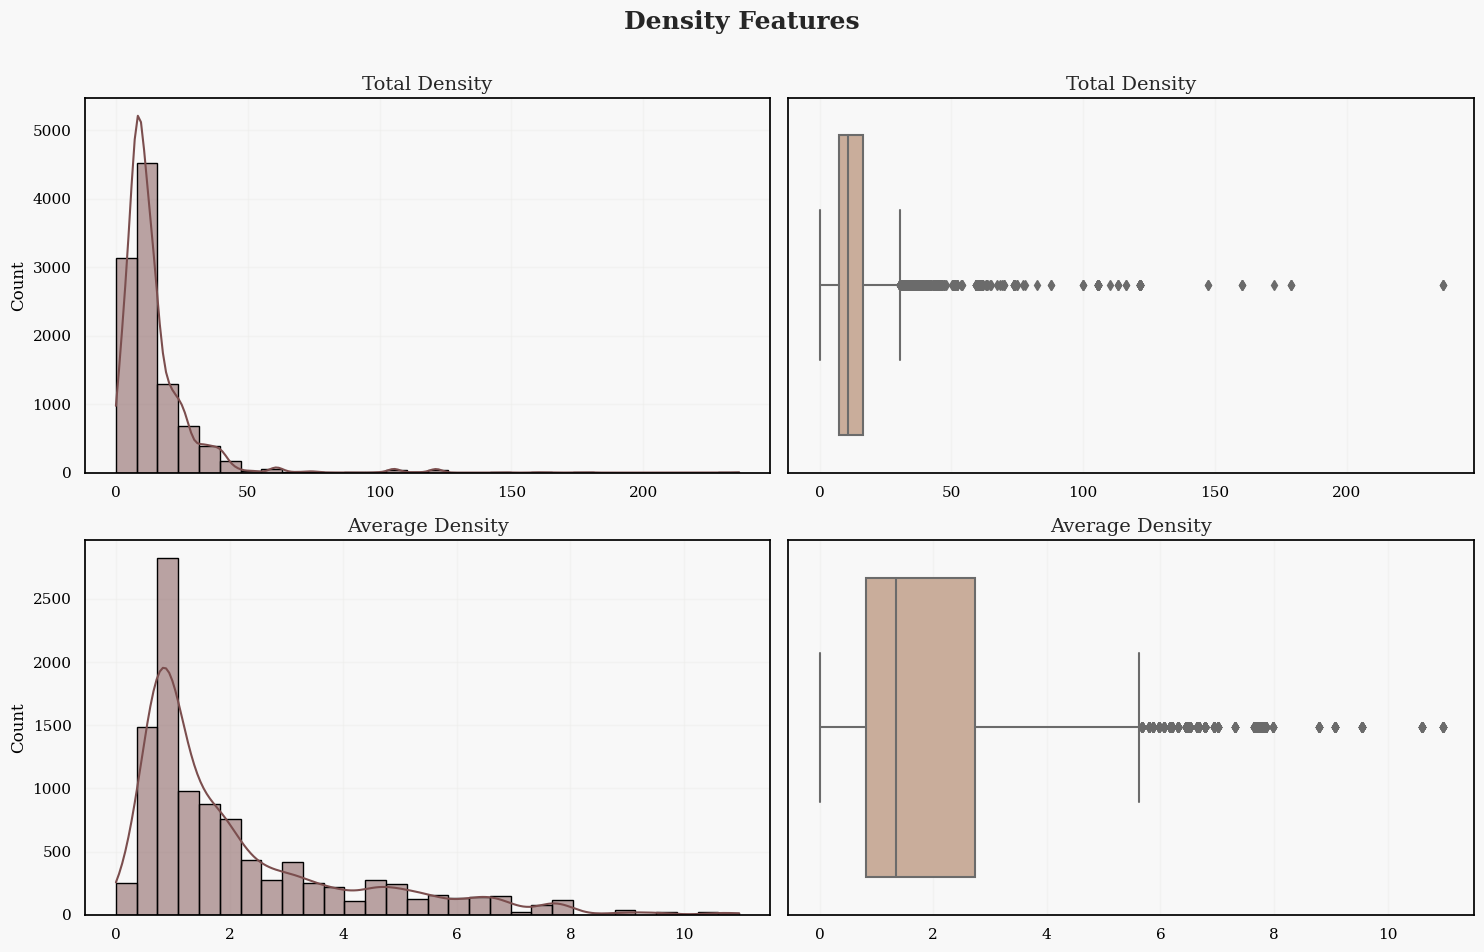

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

sns.histplot(df['density_Total'], ax=axes[0, 0], kde=True, bins=30, edgecolor='black', color=sns.color_palette("pink")[0])
axes[0, 0].set_title('Total Density', fontsize=14)
axes[0, 0].set_xlabel('')

sns.boxplot(x=df['density_Total'], ax=axes[0, 1], orient='h', palette="pink")
axes[0, 1].set_title('Total Density', fontsize=14)
axes[0, 1].set_xlabel('')

sns.histplot(df['density_Average'], ax=axes[1, 0], kde=True, bins=30, edgecolor='black', color=sns.color_palette("pink")[0])
axes[1, 0].set_title('Average Density', fontsize=14)
axes[1, 0].set_xlabel('')

sns.boxplot(x=df['density_Average'], ax=axes[1, 1], orient='h', palette="pink")
axes[1, 1].set_title('Average Density', fontsize=14)
axes[1, 1].set_xlabel('')

plt.suptitle(f'Density Features\n\n', ha='center', fontweight='bold', fontsize=18, y=0.95)
plt.tight_layout()
plt.show()

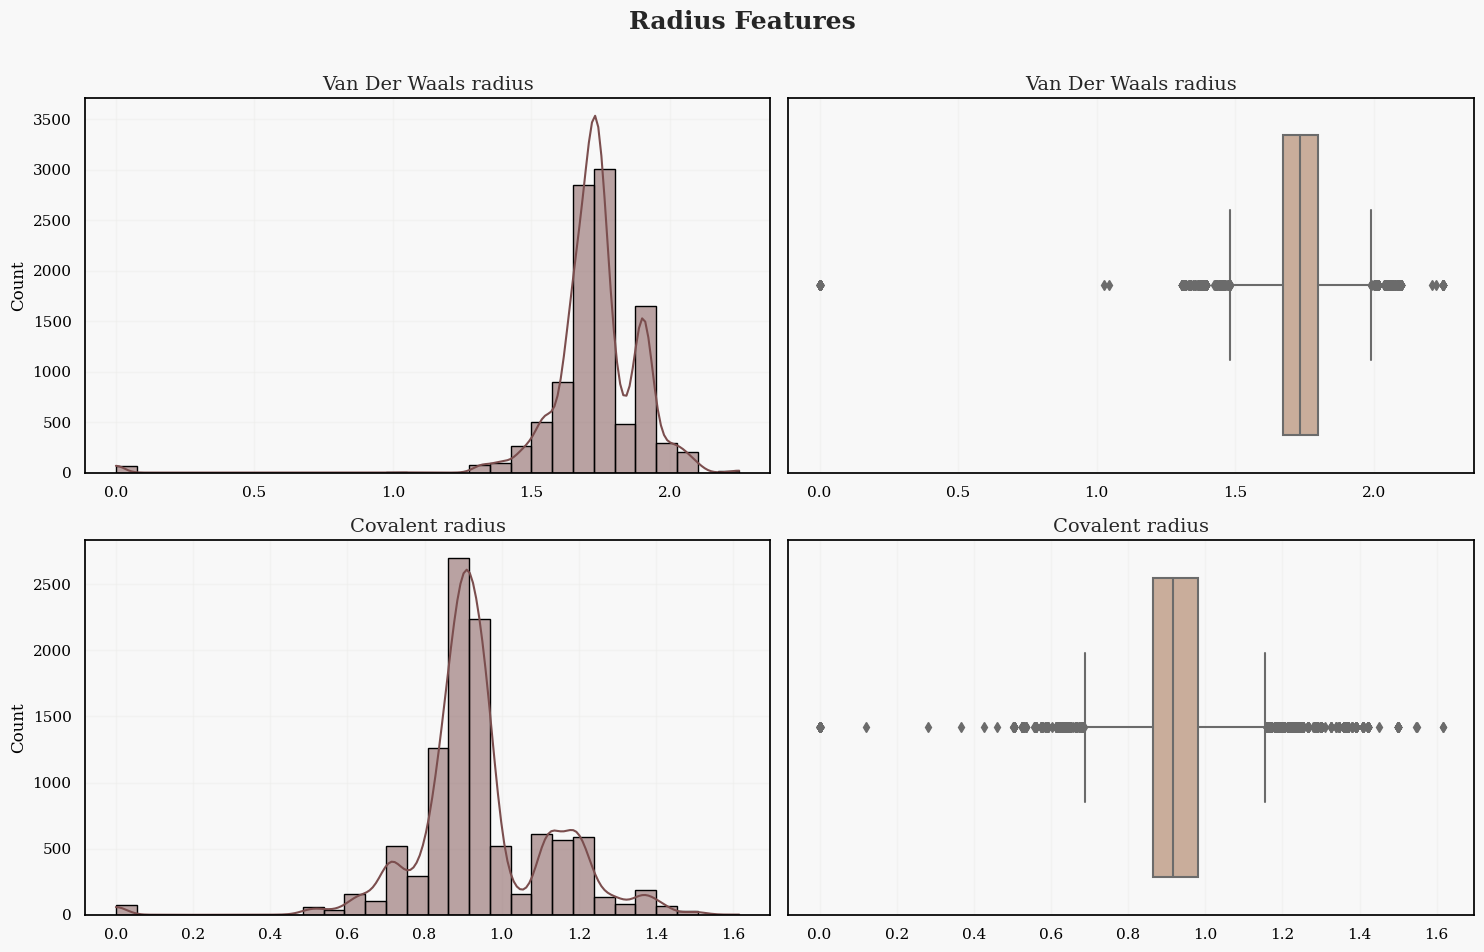

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

sns.histplot(df['R_vdw_element_Average'], ax=axes[0, 0], kde=True, bins=30, edgecolor='black', color=sns.color_palette("pink")[0])
axes[0, 0].set_title('Van Der Waals radius', fontsize=14)
axes[0, 0].set_xlabel('')

sns.boxplot(x=df['R_vdw_element_Average'], ax=axes[0, 1], orient='h', palette="pink")
axes[0, 1].set_title('Van Der Waals radius', fontsize=14)
axes[0, 1].set_xlabel('')

sns.histplot(df['R_cov_element_Average'], ax=axes[1, 0], kde=True, bins=30, edgecolor='black', color=sns.color_palette("pink")[0])
axes[1, 0].set_title('Covalent radius', fontsize=14)
axes[1, 0].set_xlabel('')

sns.boxplot(x=df['R_cov_element_Average'], ax=axes[1, 1], orient='h', palette="pink")
axes[1, 1].set_title('Covalent radius', fontsize=14)
axes[1, 1].set_xlabel('')

plt.suptitle(f'Radius Features\n\n', ha='center', fontweight='bold', fontsize=18, y=0.95)
plt.tight_layout()
plt.show()

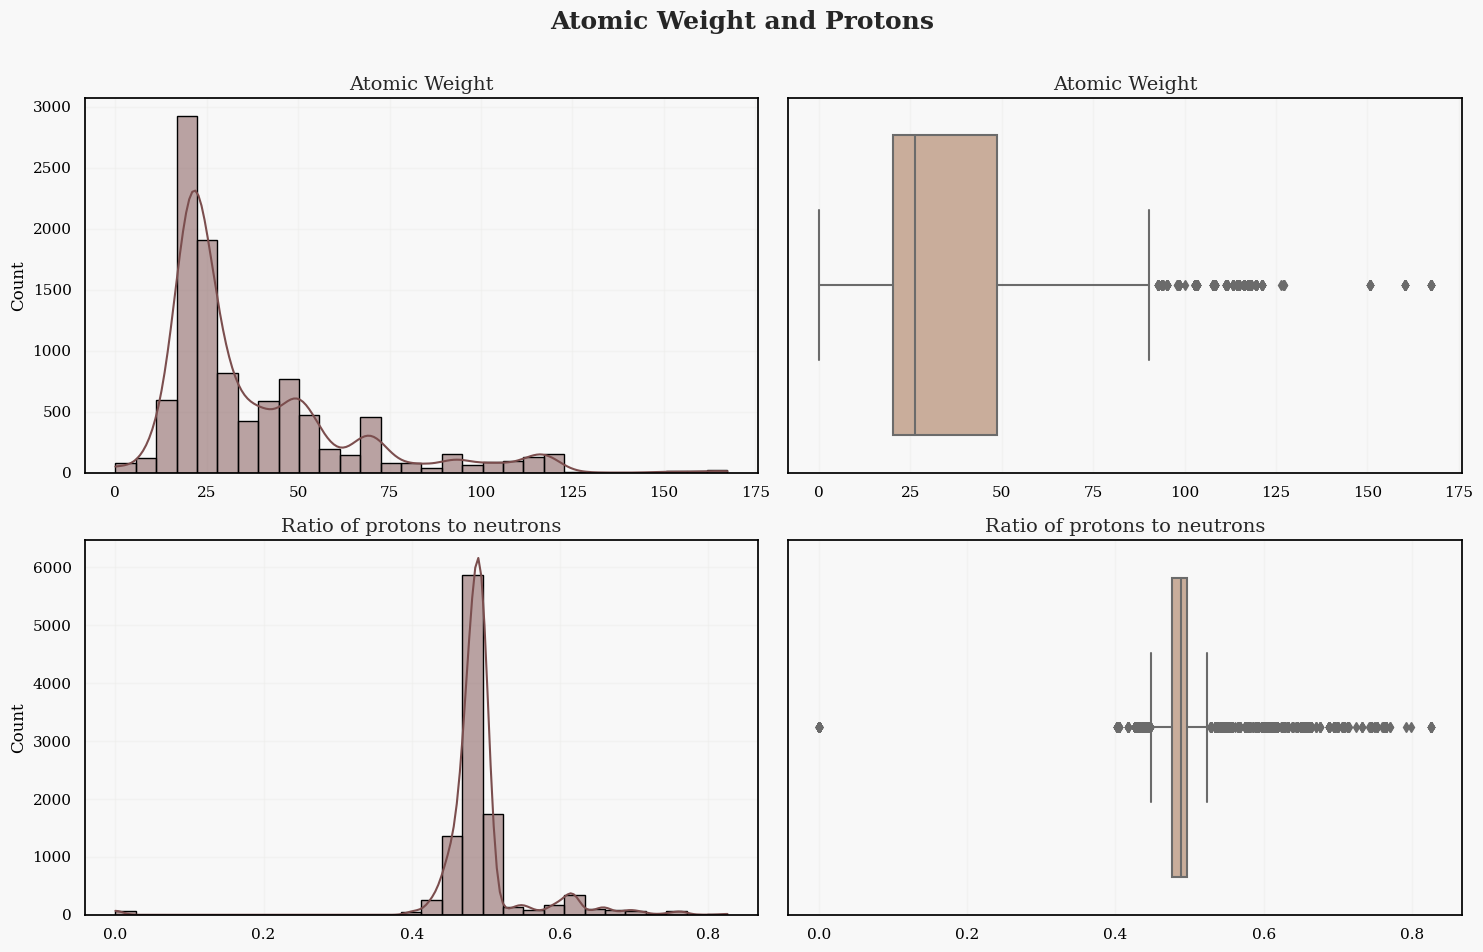

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

sns.histplot(df['atomicweight_Average'], ax=axes[0, 0], kde=True, bins=30, edgecolor='black', color=sns.color_palette("pink")[0])
axes[0, 0].set_title('Atomic Weight', fontsize=14)
axes[0, 0].set_xlabel('')

sns.boxplot(x=df['atomicweight_Average'], ax=axes[0, 1], orient='h', palette="pink")
axes[0, 1].set_title('Atomic Weight', fontsize=14)
axes[0, 1].set_xlabel('')

sns.histplot(df['zaratio_Average'], ax=axes[1, 0], kde=True, bins=30, edgecolor='black', color=sns.color_palette("pink")[0])
axes[1, 0].set_title('Ratio of protons to neutrons', fontsize=14)
axes[1, 0].set_xlabel('')

sns.boxplot(x=df['zaratio_Average'], ax=axes[1, 1], orient='h', palette="pink")
axes[1, 1].set_title('Ratio of protons to neutrons', fontsize=14)
axes[1, 1].set_xlabel('')

plt.suptitle(f'Atomic Weight and Protons\n\n', ha='center', fontweight='bold', fontsize=18, y=0.95)
plt.tight_layout()
plt.show()

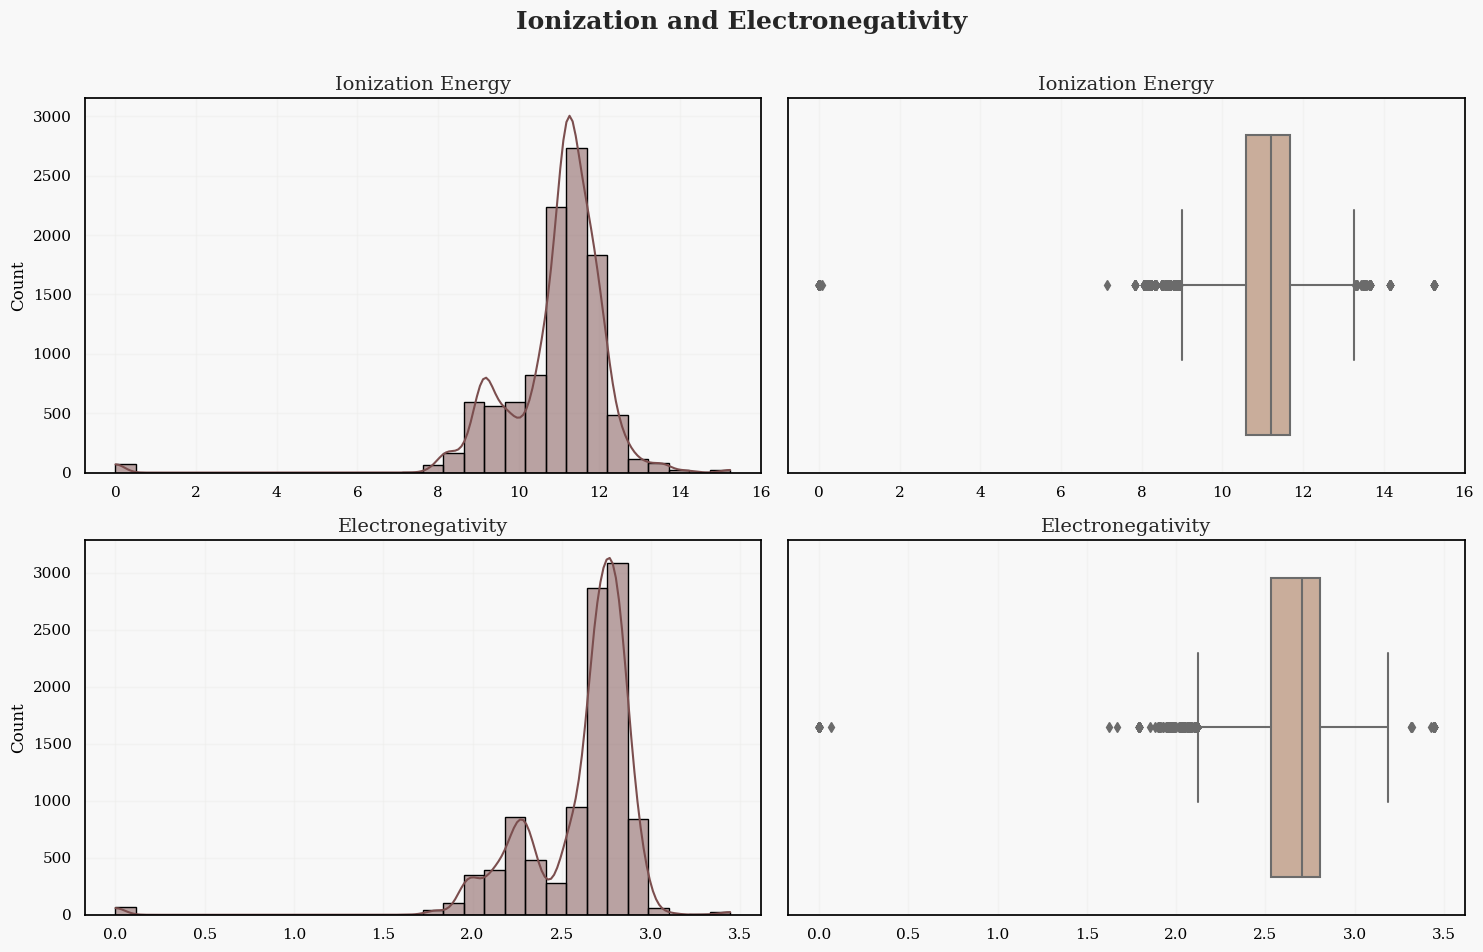

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

sns.histplot(df['ionenergy_Average'], ax=axes[0, 0], kde=True, bins=30, edgecolor='black', color=sns.color_palette("pink")[0])
axes[0, 0].set_title('Ionization Energy', fontsize=14)
axes[0, 0].set_xlabel('')

sns.boxplot(x=df['ionenergy_Average'], ax=axes[0, 1], orient='h', palette="pink")
axes[0, 1].set_title('Ionization Energy', fontsize=14)
axes[0, 1].set_xlabel('')

sns.histplot(df['el_neg_chi_Average'], ax=axes[1, 0], kde=True, bins=30, edgecolor='black', color=sns.color_palette("pink")[0])
axes[1, 0].set_title('Electronegativity', fontsize=14)
axes[1, 0].set_xlabel('')

sns.boxplot(x=df['el_neg_chi_Average'], ax=axes[1, 1], orient='h', palette="pink")
axes[1, 1].set_title('Electronegativity', fontsize=14)
axes[1, 1].set_xlabel('')

plt.suptitle(f'Ionization and Electronegativity\n\n', ha='center', fontweight='bold', fontsize=18, y=0.95)
plt.tight_layout()
plt.show()

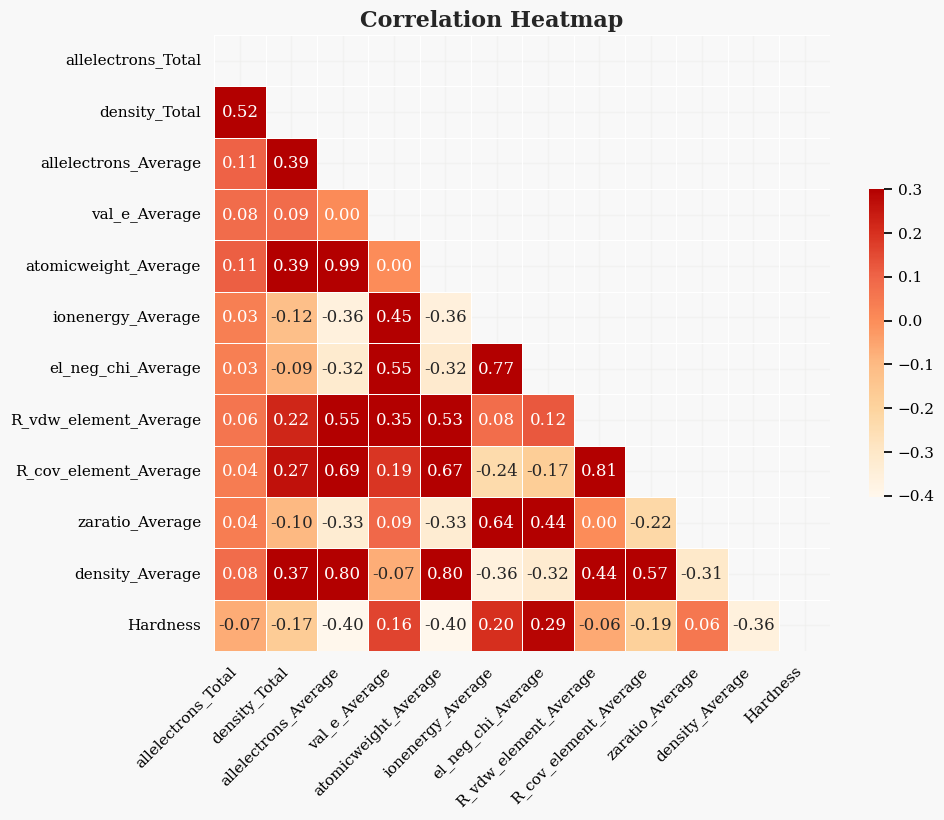

In [17]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 8))

heatmap = sns.heatmap(corr, mask=mask, cmap='OrRd', vmax=.3, center=0,
            annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

title = heatmap.set_title("Correlation Heatmap", weight='bold', size=16)
title.set_position([0.45, 1.1])
plt.show()

**Notes**
* **atomicweight_Average** and **allelectrons_Average** provide the same information.
* Another strong linear relationship is observed between **R_cov_element_Average** and **R_vdw_element_Average**

## Target Analysis
-----------------------------------------------------------------

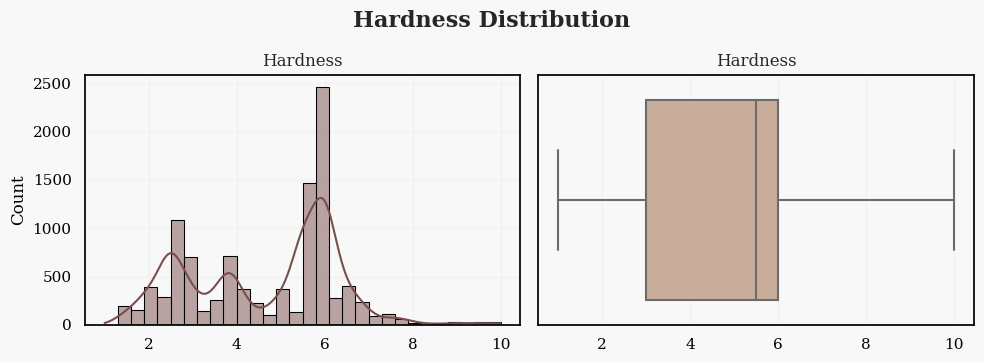

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.histplot(df['Hardness'], ax=axes[0], kde=True, bins=30, edgecolor='black', color=sns.color_palette("pink")[0])
axes[0].set_title('Hardness')
axes[0].set_xlabel('')

sns.boxplot(x=df['Hardness'], ax=axes[1], orient='h', palette="pink")
axes[1].set_title('Hardness')
axes[1].set_xlabel('')

plt.suptitle(f'Hardness Distribution\n', ha='center', fontweight='bold', fontsize=16, y=0.90)
plt.tight_layout()
plt.show()

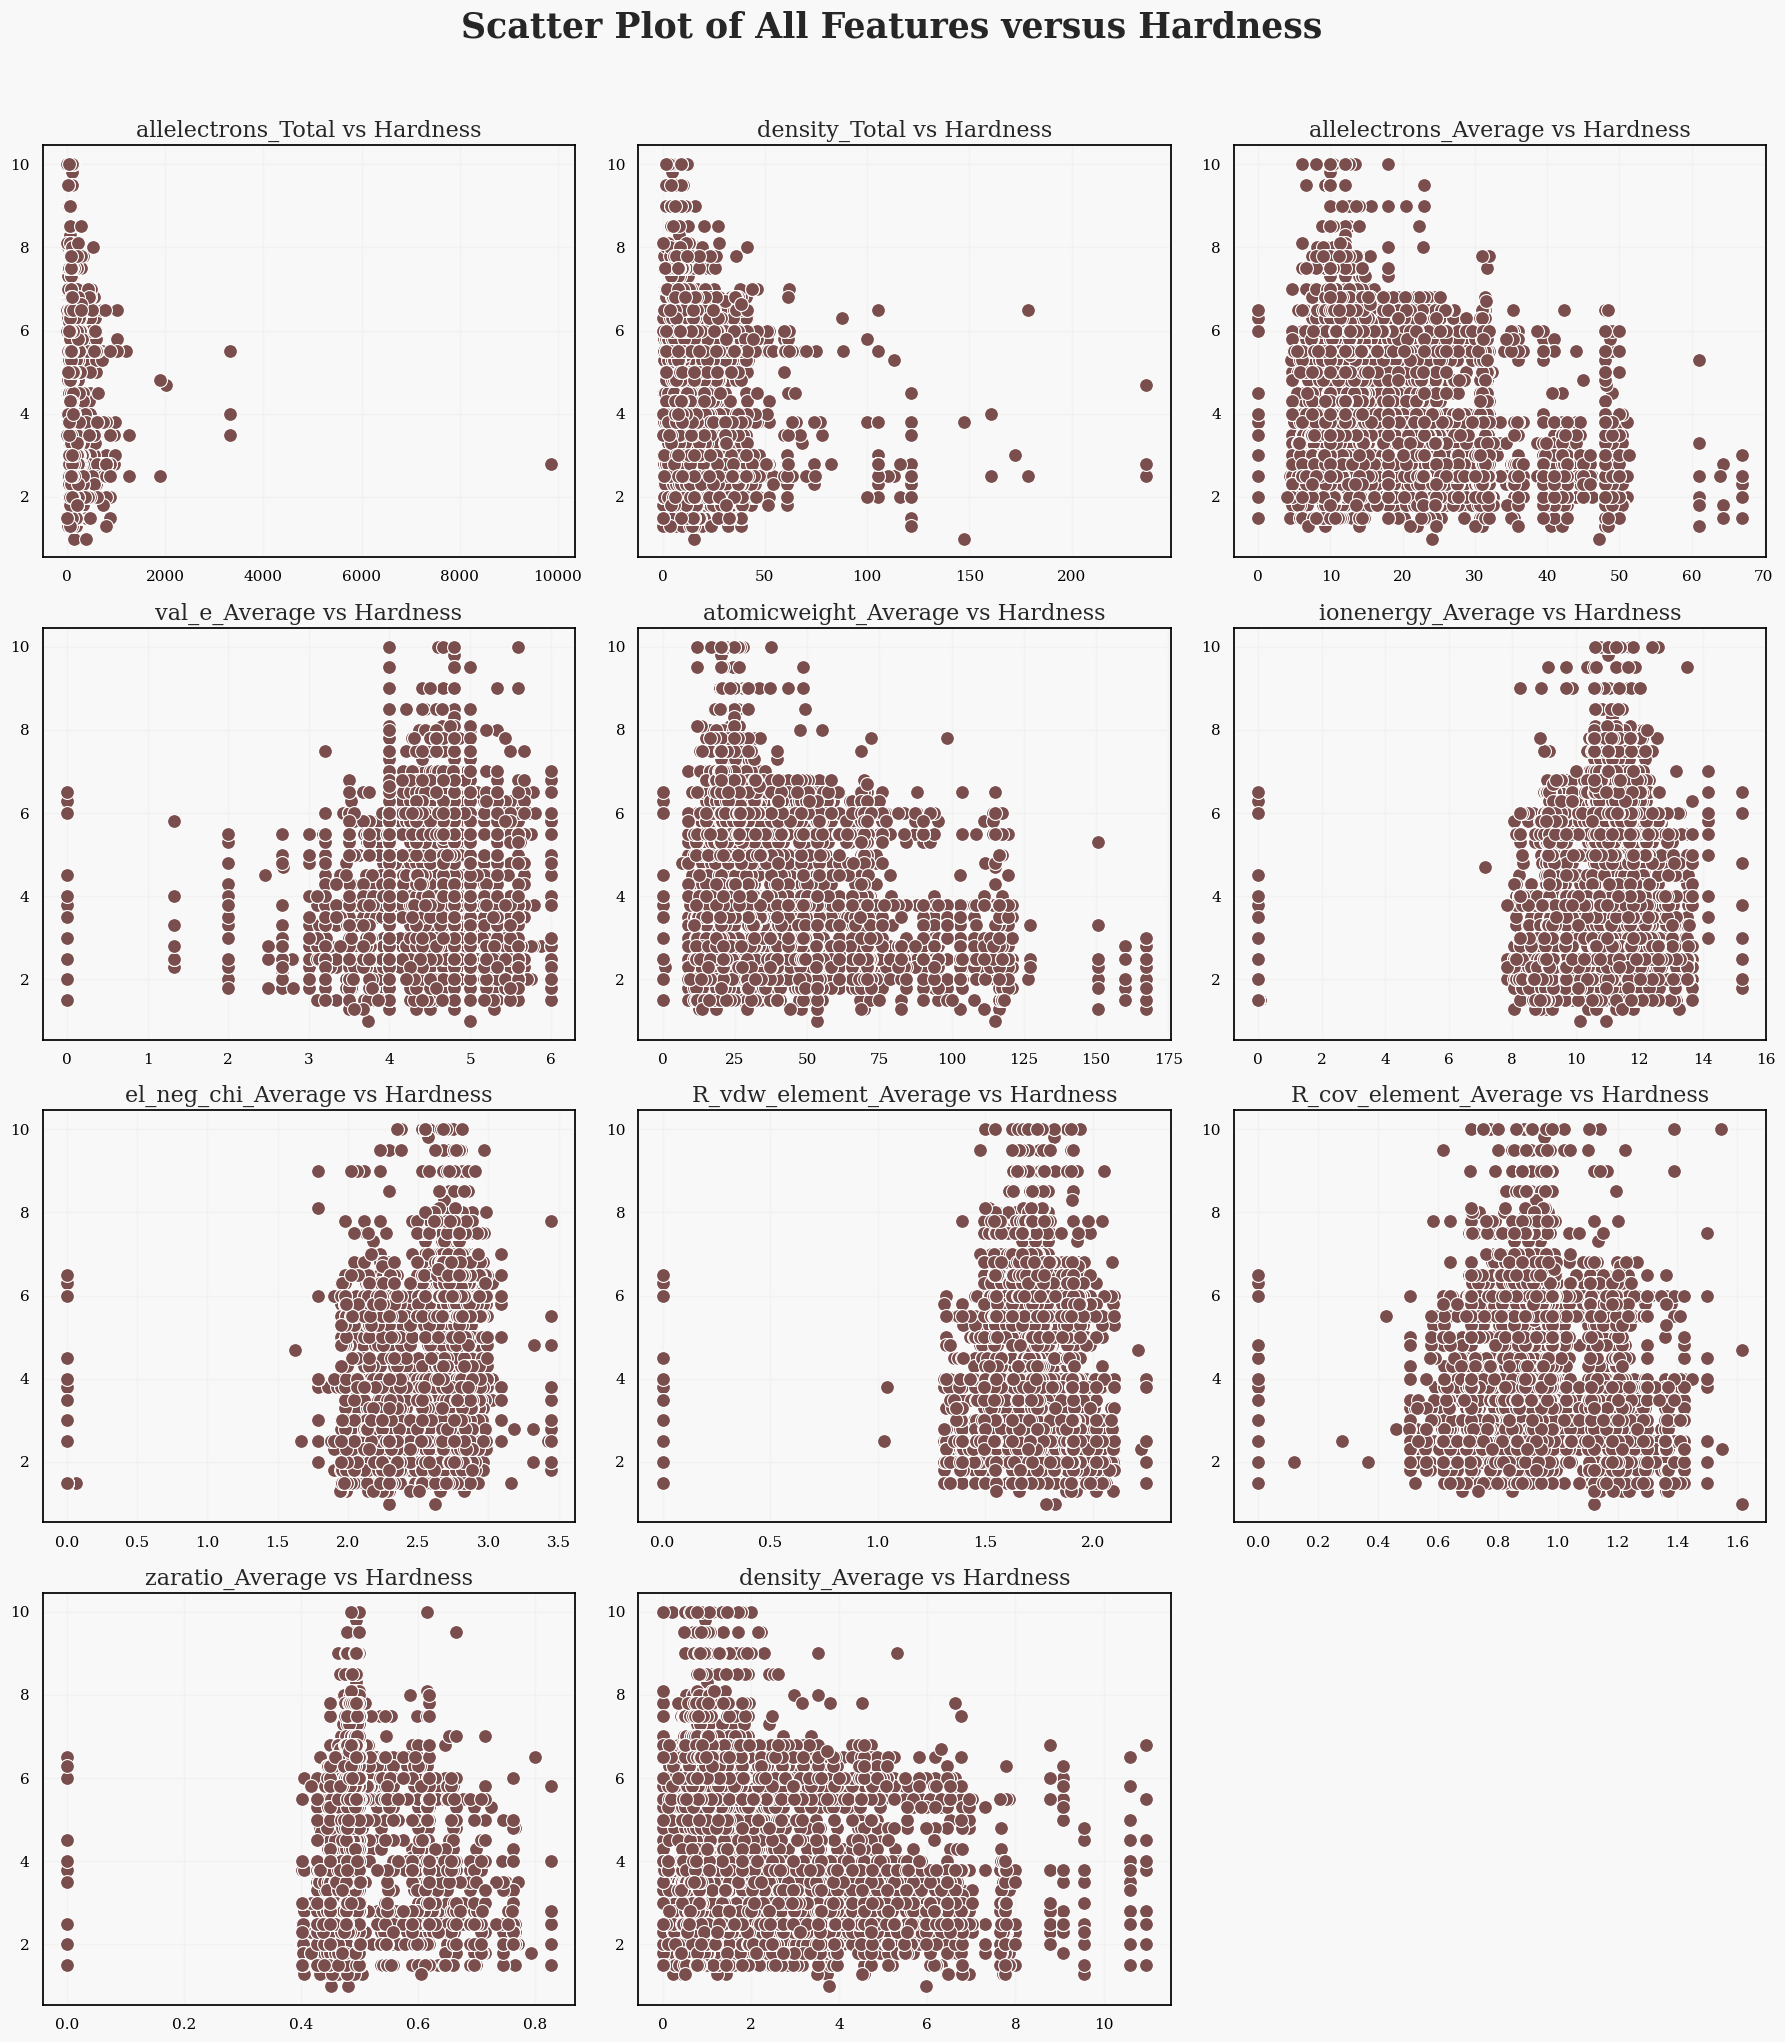

In [19]:
num_features = df.shape[1] - 1 
num_rows = (num_features + 2) // 3

fig, axes = plt.subplots(num_rows, 3, figsize=(18, 5 * num_rows))

axes = axes.flatten()

for i, feature in enumerate(df.columns):
    if feature != 'Hardness':
        sns.scatterplot(data=df, x=feature, y='Hardness', ax=axes[i], color='#7b4e4e', s=100)
        axes[i].set_title(f'{feature} vs Hardness', fontsize=16)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

for j in range(num_features, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Scatter Plot of All Features versus Hardness', ha='center', fontweight='bold', fontsize=25, y=1.02)
plt.tight_layout()
plt.show()

From the correlation heatmap, we already knew that there wasn't a strong linear relationship between the features and the target. Sometimes, a scatter plot can provide insights into how a given feature interacts with the target, but this isn't the case here.

In [20]:
from sklearn.feature_selection import mutual_info_regression
from prettytable import PrettyTable

X = df.drop('Hardness', axis=1)
y = df['Hardness']

mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, name="Mutual Information", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

pretty_table = PrettyTable()
pretty_table.field_names = ["Feature", "Mutual Information"]

for feature, mi_score in mi_scores.items():
    pretty_table.add_row([feature, round(mi_score, 3)])

print(pretty_table)

+-----------------------+--------------------+
|        Feature        | Mutual Information |
+-----------------------+--------------------+
|  atomicweight_Average |       0.501        |
|    zaratio_Average    |       0.489        |
|   ionenergy_Average   |       0.452        |
| R_cov_element_Average |       0.436        |
|   el_neg_chi_Average  |       0.413        |
| R_vdw_element_Average |        0.4         |
|  allelectrons_Average |       0.399        |
|     density_Total     |       0.334        |
|   allelectrons_Total  |       0.307        |
|     val_e_Average     |       0.283        |
|    density_Average    |       0.212        |
+-----------------------+--------------------+


We knew that **'atomicweight_Average'** and **'allelectrons_Average'** represent the same information. Mutual Information assists in determining which one we should retain. It appears that **'allelectrons_Total'** provides less information about the target.

The same line of thought can be applied to others features like **R_cov_element_Average** and **R_vdw_element_Average**

In [21]:
df.drop(columns='allelectrons_Total', inplace=True)
df.drop(columns='R_vdw_element_Average', inplace=True)
df.drop(columns='density_Average', inplace=True)

test.drop(columns='allelectrons_Total', inplace=True)
test.drop(columns='R_vdw_element_Average', inplace=True)
test.drop(columns='density_Average', inplace=True)

In [22]:
mineral_original.drop(columns='Unnamed: 0', inplace=True)
mineral_original.drop(columns='allelectrons_Total', inplace=True)
mineral_original.drop(columns='R_vdw_element_Average', inplace=True)
mineral_original.drop(columns='density_Average', inplace=True)

crystals_original.drop(columns='Unnamed: 0', inplace=True)

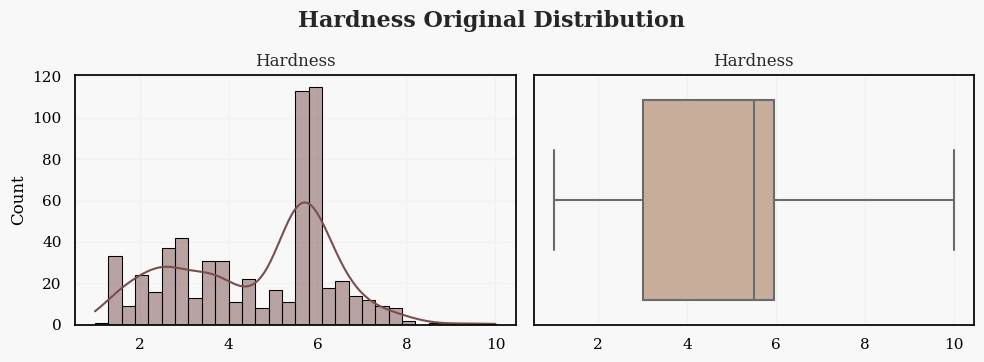

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.histplot(mineral_original['Hardness'], ax=axes[0], kde=True, bins=30, edgecolor='black', color=sns.color_palette("pink")[0])
axes[0].set_title('Hardness')
axes[0].set_xlabel('')

sns.boxplot(x=mineral_original['Hardness'], ax=axes[1], orient='h', palette="pink")
axes[1].set_title('Hardness')
axes[1].set_xlabel('')

plt.suptitle(f'Hardness Original Distribution\n', ha='center', fontweight='bold', fontsize=16, y=0.90)
plt.tight_layout()
plt.show()

In [24]:
from scipy.stats import kurtosis

statistics = ['mean', 'median', 'std', 'kurtosis', 'min', 'max']

table = PrettyTable()
table.field_names = ["Statistic", "Original Hardness", "Train Hardness"]

for stat in statistics:
    if stat == 'kurtosis':
        original_stat = round(mineral_original['Hardness'].kurtosis(), 2)
        train_stat = round(df['Hardness'].kurtosis(), 2)
    else:
        original_stat = round(getattr(mineral_original['Hardness'], stat)(), 2)
        train_stat = round(getattr(df['Hardness'], stat)(), 2)
    table.add_row([stat, original_stat, train_stat])

print(table)

+-----------+-------------------+----------------+
| Statistic | Original Hardness | Train Hardness |
+-----------+-------------------+----------------+
|    mean   |        4.61       |      4.65      |
|   median  |        5.5        |      5.5       |
|    std    |        1.73       |      1.68      |
|  kurtosis |       -0.84       |     -0.79      |
|    min    |        1.0        |      1.0       |
|    max    |        10.0       |      10.0      |
+-----------+-------------------+----------------+


Statistical measures for our target on both dataframes are similar, so we will use the original data for training. 

In [25]:
df = pd.concat([mineral_original, df])
df = df.reset_index(drop=True)

In [26]:
df.shape

(11028, 9)

## Crystal Structure Data
--------------------------------------------------------------------------

We have some metadata available; let's try to utilize it. The **'Crystal structure'** feature is the most straightforward to use since it contains multiple categorical values for a given target.


In [27]:
crystals_original['Crystal structure'] = crystals_original['Crystal structure'].fillna('not known')

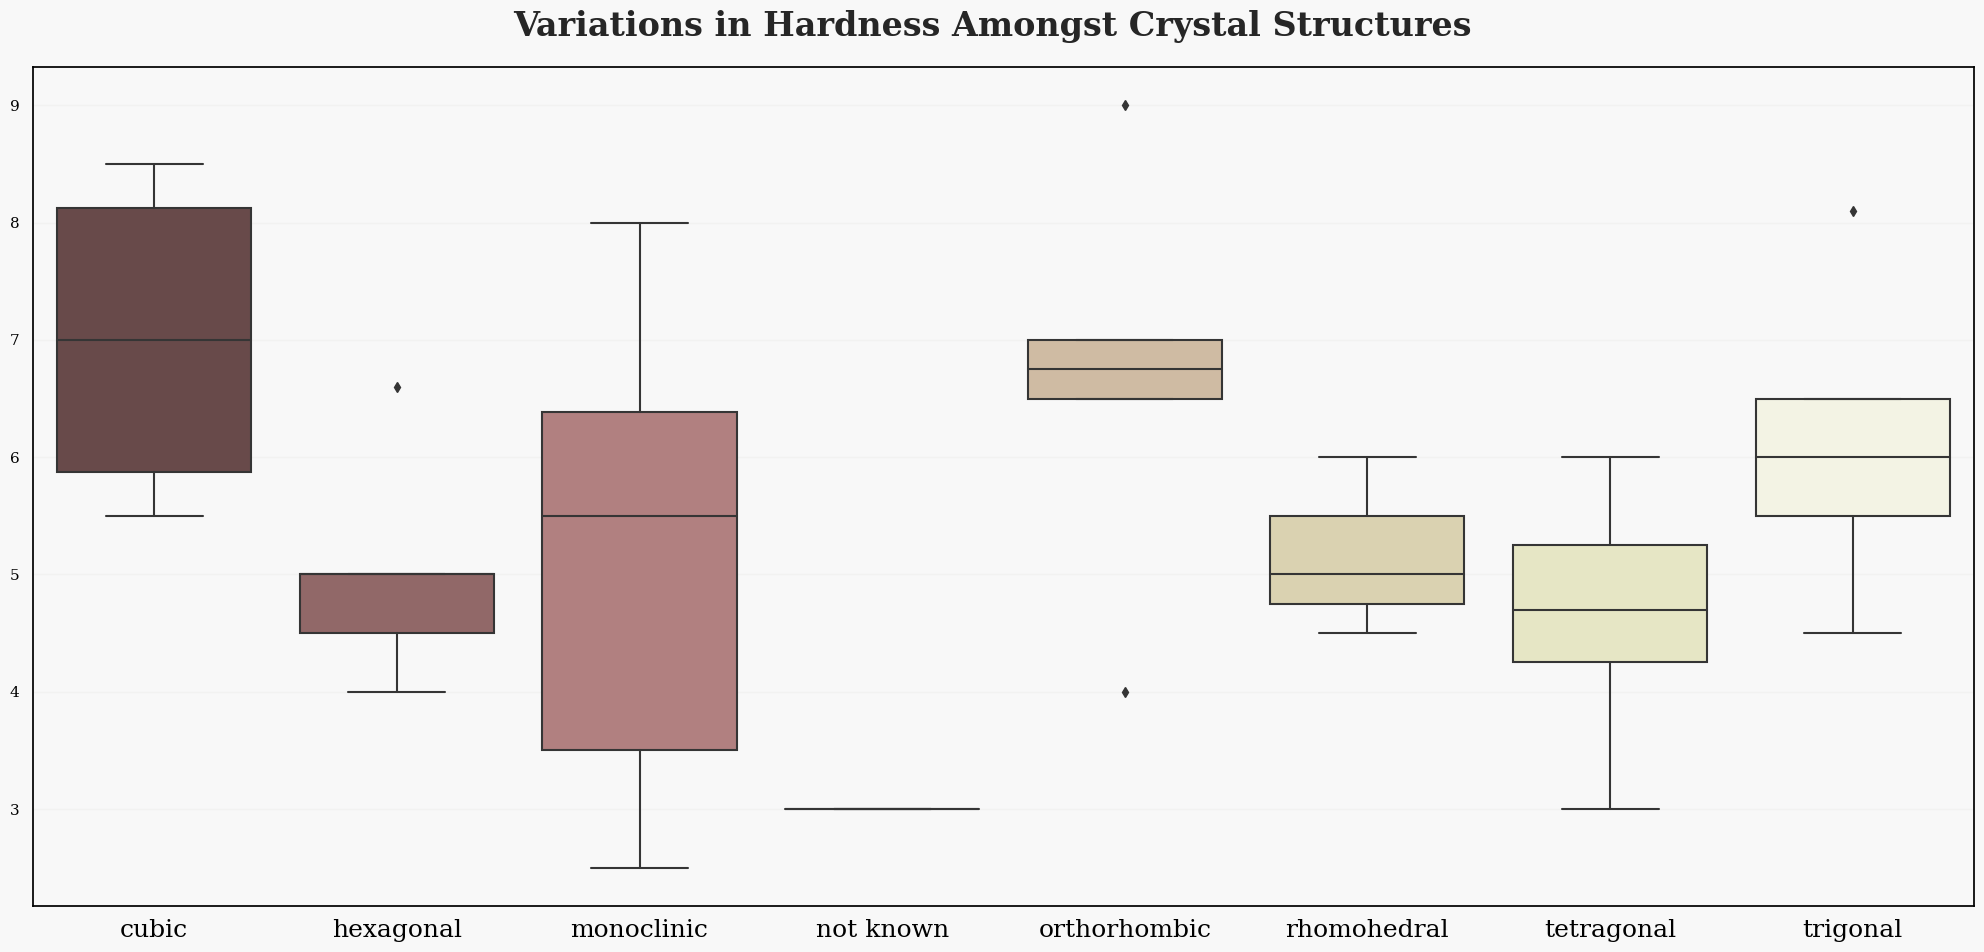

In [28]:
plt.figure(figsize=(20, 10))
sorted_structures = sorted(crystals_original['Crystal structure'].unique())

sns.boxplot(x='Crystal structure', y='Hardness (Mohs)', data=crystals_original, palette='pink',
            order=sorted_structures)
plt.xticks(rotation=0, fontsize=18)
plt.title('')
plt.xlabel('')
plt.ylabel('')

plt.suptitle(f'Variations in Hardness Amongst Crystal Structures\n', ha='center', fontweight='bold', fontsize=24, y=0.95)
plt.tight_layout()
plt.show()

Each crystal structure displays a unique distribution and statistical characteristics of hardness, which suggests its potential as a distinguishing feature. However, as the training set lacks information on the crystal structure, we will develop a model to estimate this attribute in both the training and testing datasets.

In [29]:
from sklearn.neighbors import NearestNeighbors

common_columns_df = [col for col in df.columns if col in crystals_original.columns]
X_original = crystals_original[common_columns_df]
X_train = df[common_columns_df]

nn = NearestNeighbors(n_neighbors=1, p=2)
nn.fit(X_original)
distances_df, indices_df = nn.kneighbors(X_train)
df['Crystal structure'] = crystals_original.iloc[indices_df.flatten()]['Crystal structure'].values

common_columns_test = [col for col in test.columns if col in crystals_original.columns]
X_test = test[common_columns_test]

distances_test, indices_test = nn.kneighbors(X_test)
test['Crystal structure'] = crystals_original.iloc[indices_test.flatten()]['Crystal structure'].values

We employ a Nearest Neighbors model, specifically trained on the metadata, to identify the closest similar entry for each record in both the 'df' and 'test' datasets. This identification is based on Euclidean distance. Once the closest neighbor is found, we transfer the 'Crystal structure' values from these nearest entries in 'crystals_original' to their corresponding counterparts in 'df' and 'test'.

This approach imputes missing 'Crystal structure' data in 'df' and 'test', utilizing the underlying principle that chemically similar compounds are likely to share comparable crystal structures.

## CatBoost
----------------------------------------------------------

Fold 1 MAE: 0.4914, Variance: 0.8384
Fold 2 MAE: 0.5284, Variance: 0.9042
Fold 3 MAE: 0.5162, Variance: 0.7982
Fold 4 MAE: 0.5041, Variance: 0.7615
Fold 5 MAE: 0.5024, Variance: 0.7726
Fold 6 MAE: 0.5222, Variance: 0.7721
Fold 7 MAE: 0.4997, Variance: 0.8283
Fold 8 MAE: 0.5075, Variance: 0.8571
Fold 9 MAE: 0.4983, Variance: 0.7358
Fold 10 MAE: 0.4777, Variance: 0.7480

Overall MAE for OOF predictions: 0.5047


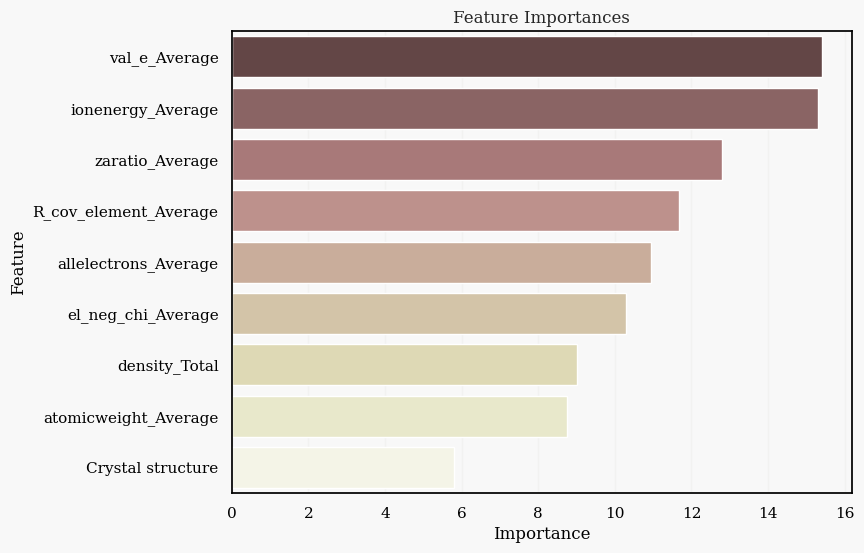

In [30]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.metrics import median_absolute_error

params = {
    'verbose': False,
    'random_seed': 42,
    'iterations': 3000,
    'loss_function': 'MAE',
    'depth': 8,
    'learning_rate': 0.05812438530186216,
    'l2_leaf_reg': 6.3300582449650005
}

target = 'Hardness'
X = df.drop(columns=target)
y = df[target].values
feature_names = X.columns.tolist()
cat_features = ['Crystal structure']

for cat_feature in cat_features:
    X[cat_feature] = X[cat_feature].astype(str)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

fold_num = 1
oof_preds = np.zeros(y.shape)
models = []
eval_results_list = []
results_df = pd.DataFrame(columns=["Hardness_predicted", "Hardness_true"])
feature_importances = np.zeros(X.shape[1])

for train_index, valid_index in kf.split(X, y):
    xtrain, xvalid = X.iloc[train_index], X.iloc[valid_index]
    ytrain, yvalid = y[train_index], y[valid_index]

    train_pool = Pool(xtrain, ytrain, feature_names=feature_names, cat_features=cat_features)
    valid_pool = Pool(xvalid, yvalid, feature_names=feature_names, cat_features=cat_features)

    cat_model = CatBoostRegressor(**params)
    cat_model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=250)
    models.append(cat_model)
    
    eval_result = cat_model.eval_metrics(valid_pool, ['MAE'])
    eval_results_list.append(eval_result)

    feature_importances += cat_model.get_feature_importance()

    fold_preds = cat_model.predict(xvalid)
    oof_preds[valid_index] = fold_preds

    temp_df = pd.DataFrame({
        "Hardness_predicted": fold_preds,
        "Hardness_true": yvalid,
    })
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

    fold_mae = median_absolute_error(yvalid, fold_preds)
    fold_variance = np.var(np.abs(fold_preds - yvalid))
    print(f"Fold {fold_num} MAE: {fold_mae:.4f}, Variance: {fold_variance:.4f}")
    fold_num += 1

feature_importances /= kf.get_n_splits()

final_mae = median_absolute_error(y, oof_preds)
print(f"\nOverall MAE for OOF predictions: {final_mae:.4f}")

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=importance_df, y='Feature', x='Importance', palette='pink')
plt.title('Feature Importances')
plt.show()

High variance of the folds is something we should worry about. On the other hand, it's good to know that the model is not overfitting to any specific feature.

In [31]:
results_df['Diff'] = results_df['Hardness_true'] - results_df['Hardness_predicted']
results_df = results_df.sort_values(by='Diff', key=abs, ascending=False)
results_df.head(10)

,Hardness_predicted,Hardness_true,Diff
7719,3.316624,10.0,6.683376
7661,3.592361,9.5,5.907639
7868,3.115898,9.0,5.884102
1306,2.876175,8.5,5.623825
8732,3.958442,9.5,5.541558
8027,4.554759,10.0,5.445241
8674,4.138349,9.5,5.361651
1481,3.652167,9.0,5.347833
197,4.319101,9.5,5.180899
7466,2.663625,7.8,5.136375


As expected, the model has trouble predicting the higher end of the target distribution.

Text(0.5, 1.0, 'Histogram of predictions')

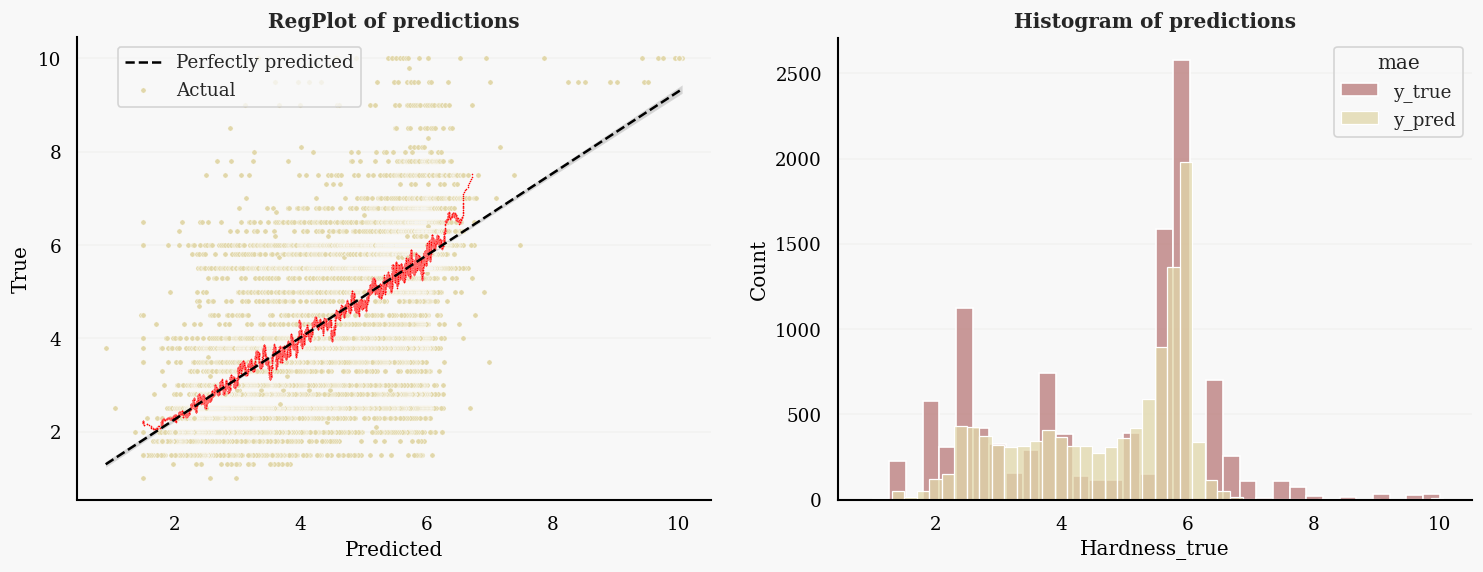

In [32]:
sort_idxs = np.argsort(oof_preds)
oof_sorted = oof_preds[sort_idxs]
y_true_sorted = df['Hardness'].iloc[sort_idxs]
y_true_sorted = pd.Series(y_true_sorted.values, index=oof_sorted)
y_roll_mean = y_true_sorted.rolling(80, center=True).mean()

palette = sns.color_palette("pink", 2)

fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=120)
ax = ax.flatten()

sns.regplot(data=results_df, x='Hardness_predicted', y='Hardness_true', color=palette[1], scatter=False,
            line_kws={"color": "black", "linestyle": "--", "lw": 1.5}, ax=ax[0], label='Perfectly predicted')

sns.scatterplot(data=results_df, x='Hardness_predicted', y='Hardness_true', s=10, color=palette[1], ax=ax[0], label='Actual')
sns.scatterplot(x=y_roll_mean.index, y=y_roll_mean, color='red', s=1, ax=ax[0])

ax[0].legend(bbox_to_anchor=(0.05, 1), loc='upper left')
ax[0].set(xlabel='Predicted', ylabel='True')

sns.histplot(results_df['Hardness_true'], color=palette[0], label='y_true', ax=ax[1])
sns.histplot(results_df['Hardness_predicted'], color=palette[1], label='y_pred', ax=ax[1])
ax[1].legend(bbox_to_anchor=(1, 1), loc='upper right', title='mae')
for i, _ in enumerate(ax):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].xaxis.grid(False)
    ax[i].yaxis.grid(True)

ax[0].set_title(f'RegPlot of predictions', fontdict={'fontweight': 'bold'})
ax[1].set_title(f'Histogram of predictions', fontdict={'fontweight': 'bold'})

## Submission
---------------------------------------------------------------

In [33]:
columns_order = df.drop(columns=[target]).columns.tolist()
test = test[columns_order]

In [34]:
test_preds_catboost = np.zeros(test.shape[0])

for cat_model in models:
    test_preds_catboost += cat_model.predict(test)

test_preds_catboost /= len(models)

test['Hardness'] = test_preds_catboost

In [35]:
submission['Hardness'] = test['Hardness']

In [36]:
submission.to_csv(r"submission.csv", index=False)

In [37]:
submission

,id,Hardness
0,10407,2.499705
1,10408,2.509314
2,10409,5.926495
3,10410,4.423689
4,10411,5.001112
...,...,...
6934,17341,5.600602
6935,17342,3.995184
6936,17343,5.159921
6937,17344,4.925273
